<h2>Project 8: Deep Learning</h2>


<h3>Introduction</h3>
In this project, you will implement a neural network.
We broke it apart into several functions and a pre-processing step.</p>


In [1]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
#</GRADED>
import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
import sys
from scipy.io import loadmat
import time

# add p8 folder
sys.path.insert(0, './p8/')

%matplotlib inline

 <p> 
  An important step to make neural networks function properly is to scale the data properly. Therefore, first implement the preprocess function.
  It takes as input the training and the test data and transforms them both with the same mapping: $\vec x_i\rightarrow U\vec x_i-\vec{m}$. 
  After this transformation the training data set should have zero-mean and each feature should have standard deviation 1 . The same transformation is then also applied to the test data (Hint: The matrix U is typically diagonal.) 
  <!--	 <li>HINT 2: Ideally you would like the input features to be de-correlated. The correlation matrix should be diagonal (in this case even the identity matrix). One way to do this is to project the data onto the PCA principal components (which we will still cover later in the course). You can get the transposed projection matrix by calling $pcacov(xTr')$. Make sure to apply PCA <i>after</i> you subtracted off the mean. </li>-->
  </p>

In [1]:
#<GRADED>
def preprocess(xTr, xTe):
    """
    Preproces the data to make the training features have zero-mean and
    standard-deviation 1
    OUPUT:
        xTr - nxd training data
        xTe - mxd testing data
    OUPUT:
        xTr - pre-processed training data
        xTe - pre-processed testing data
        s,m - standard deviation and mean of xTr
            - any other data should be pre-processed by x-> (x-m)/s
    (The size of xTr and xTe should remain unchanged)
    """
    
    ntr, d = xTr.shape
    nte, _ = xTe.shape
    
    ## TODO 1
    
    
    

        
    m=np.mean(xTr)
    s=np.std(xTr)
    
    xTr=(xTr-m)/s
    xTe=(xTe-m)/s
    

    
    ## TODO 1

    return xTr, xTe, s, m
#</GRADED>

<p> 
  Now you need to implement three transition functions: <code>ReLU, sigmoid</code> and <code>tanh</code>.
 </p>
 <ol>
     <li>ReLU: $\sigma(z) = \max(0, z)$</li>
     <li>Sigmoid: $\sigma(z) = \frac{1}{1 + e^{-z}}$</li>
     <li>tanh: $\sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$</li>
 </ol>
 <p> 
  Note that the functions should support vectors and matrices as an input. All of these are elementwise functions, so as long as you use numpy operations that support matrices you should be good.
    Also since the operations are element wise, the output of the derivative function will have the same shape as the input, and the elements would essentially be taking the derivative elementwise.
 </p>

In [2]:
#<GRADED>
def get_transition_func(transtype):
    """
    Given the type, gets a specific transition function
    INPUT:
        transtype - "sigmoid", "tanh", "ReLU", "sin"
    OUTPUT:
        trans_func - transition function (function)
        trans_func_der - derivative of the transition function (function)

    (type must be one of the defined transition functions)
    """
    
    assert transtype in ["sigmoid", "tanh", "ReLU","sin"]
    if transtype == "sin":   
        trans_func = lambda z: np.sin(z)
        trans_func_der = lambda z: np.cos(z)
    ## TODO 2
    elif transtype == "sigmoid":
        trans_func = lambda z: 1/(1 + np.exp(-z))
        trans_func_der = lambda z: np.exp(-z)/(1+np.exp(-z))**2
        
    elif transtype == "tanh":
        trans_func = lambda z: np.tanh(z)
        trans_func_der = lambda z: 1 - np.square(np.tanh(z))
        
    elif transtype == "ReLU":
        trans_func = lambda z: (np.maximum(0,z))
        trans_func_der = lambda z: np.sign(np.maximum(0,z)) 
    ## TODO 2
    
    return trans_func, trans_func_der
#</GRADED>

<p>If everything is correct we can now plot these functions and check their gradients. The gradient errors should all be very small (less than $10^{-10}$.) </p>

In [48]:
def numericalgradient(fun,x,e):
    dh = 0
    nx = x    # copy the weight vector
    nx += e  # perturn dimension i
    l1 = fun(nx) # compute loss
    nx -= 2*e # perturm dimension i again
    l2 = fun(nx) # compute loss
    dh = (l1 - l2)/(2*e) # the gradient is the slope of the loss
    return dh

sigmoid gradient check at x=1: passed at x=-1: passed
tanh gradient check at x=1: passed at x=-1: passed
ReLU gradient check at x=1: passed at x=-1: passed
sin gradient check at x=1: passed at x=-1: passed


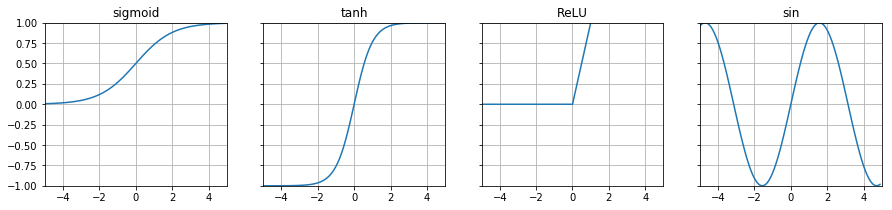

In [49]:
fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(3)
names = ["sigmoid","tanh","ReLU","sin"]

for idx, name in enumerate(names):
    # plot stuff
    f, delta_f = get_transition_func(name)
    x = np.arange(-5, 5, 0.1)
    axarr[idx].plot(x, f(x))
    axarr[idx].axis([-5,5,-1,1])
    axarr[idx].title.set_text(name)
    axarr[idx].grid(True)
    
    # check gradients
    print("%s gradient check at x=1: " % name, end='')
    dh = numericalgradient(f,1,1e-5)
    dy = delta_f(1)
    num = np.linalg.norm(dh-dy)
    denom = np.linalg.norm(dh+dy)
    graderror = num/denom if denom != 0 else 0
    if graderror < 1e-10:
        print("passed ", end='')
    else:
        print("FAILED ", end='')
    print('at x=-1: ', end='')
    dh2 = numericalgradient(f,-1,1e-5)
    dy2 = delta_f(-1)
    num = np.linalg.norm(dh2-dy2)
    denom = np.linalg.norm(dh2+dy2)
    graderror += num/denom if denom != 0 else 0
    if graderror < 1e-10:
        print("passed")
    else:
        print("FAILED")

<p>
The following function will randomly generate initial weights for the neural network.
</p>

In [50]:
def initweights(specs):
    """
    Given a specification of the neural network, output a random weight array
    INPUT:
        specs - array of length m+1
    
    OUTPUT:
        weights - array of length m, each element is a matrix
            where size(weights[i]) = (specs[i], specs[i+1])
    """
    weights = []
    for i in range(len(specs) - 1):
        weights.append(np.random.randn(specs[i], specs[i+1]))
    return weights


Now implement the forward pass function
  <pre>forward_pass(W,xTr,trans_func)</pre>
  It takes the weights for the network, the training data, and the transition function to be used between layers.  It should output the result at each node for the forward pass.
  
  Each layer has two outputs, $A[i]$ and $Z[i]$, where $A[i]=Z[i-1] * weights[i-1]$ and $Z[i]=trans\_func(A[i])$.
  
  $weights[0]$ stores the weights for the first layer of the network.
  </p>
  </li>



In [51]:
#<GRADED>
def forward_pass(weights, xTr, trans_func):
    """
    INPUT:
        weights - weights (cell array of length m)
        xTr - nxd matrix (each row is an input vector)
        trans_func - transition function to apply for inner layers
    
    OUTPUTS:
        A, Z - result of forward pass (cell array of length m+1)
    
    Hint:
        Make sure A[0]=Z[0]=xTr and A[m] = Z[m] (Why?)
    """
    
    ## TODO 3
    n = xTr.shape[0]
    m = len(weights)
    
    A = []
    Z = []
    A.append(xTr)
    Z.append(xTr)
    
    for i in range(m):
        A.append(np.matmul(Z[i],weights[i]))
        if ((i+1) == m):
            Z.append(A[-1])
        else:
            Z.append(trans_func(A[i+1]))

        
    ## TODO 3
    return A, Z
#</GRADED>

In [52]:
weights=initweights([2,20,20,1])



f,delta_f=get_transition_func("sigmoid")
x=np.random.rand(100,2);
A,Z=forward_pass(weights,x,f)

Now implement the function to compute the loss for the network
  <pre>compute_loss(zs, yTr)</pre>
  It takes the output of the forward pass and the training labels.  It should compute the loss for the entire training set averaging over all the points:
  $$L(x, y) = \frac{1}{2n}\sum_{i=1}^{n}(H(x_i) - y_i)^2$$
  </p>
  </li>

In [53]:
#<GRADED>
def compute_loss(Z, yTr):
    """
    INPUT:
        Z - output of forward pass (cell array of length m+1)
        yTr - array of length n
    
    OUTPUTS:
        loss - the average squared loss obtained with Z and yTr (scalar)
    """
    
    delta = Z[-1].flatten() - yTr.flatten()
    n = len(yTr)
    loss = 0

    ## TODO 4
    initial = 0
    for i in range (n):
        initial = initial + (delta[i]**2)
    loss = (1/(2*n)) * initial
    
    ## TODO 4

    return loss
#</GRADED>

In [54]:
yTr = np.random.rand(100)
compute_loss(Z,yTr)

0.2484219368260299

Now implement <i>back propagation</i> 
  <pre>backprop(W, as, zs, yTr,  der_trans_func)</pre>
  to compute the gradient for the weights and bias terms. 
  It takes the weights for the network, the outputs of the forward pass, the training labels, and the derivative of the transition function.  Use the chain rule to calculate the gradient of the weights.
  
Hint: For finding the partial derivative for the weight in a matrix multipication $F(X) = WX$ with respect to a loss $L$ is $\frac{\partial L}{\partial W} = \frac{\partial L}{\partial F(X)}X^T$
  </p></li>
  		




In [55]:
#<GRADED>
def backprop(weights, A, Z, yTr, delta_f):
    """
    INPUT:
        weights - weights (cell array of length m)
        A - output of forward pass (cell array of length m+1)
        Z - output of forward pass (cell array of length m+1)
        yTr - array of length n
        delta_f - derivative of transition function to apply for inner layers
    
    OUTPUTS:
        gradient - the gradient at w (cell array of length m)
    """
    
    yTr = yTr.reshape(-1,1)
    n,_ = yTr.shape
    delta = (Z[-1].flatten() - yTr.flatten()).reshape(-1, 1)
    
    # compute gradient with back-prop
    gradients = []
    
    ## TODO 5
    m = len(weights)-1
    
    gradient = np.transpose(np.dot(np.transpose(delta),Z[m]))/n
    delta = np.dot(delta, np.transpose(weights[m]))
    gradients.append(gradient)                         
    
    j = m - 1
    while (j>=0):
        gradient = np.dot(np.transpose(Z[j]), (np.multiply(delta,delta_f(A[j+1]))))/n
        delta = np.dot(np.multiply(delta,delta_f(A[j+1])), np.transpose(weights[j]))
        gradients.append(gradient)
        j = j-1
        
        
    gradients.reverse()
        
    """
        grad = np.matmul(weights(m),np.multiply(delta_f(A[m]),grad))
        gradients.append(grad)
        
        delta/n*delta_f(A[-1])
    """
    ## TODO 5
    
    return gradients
#</GRADED>

<p>The following function will plot the results of prediction and the loss.</p>

In [56]:
def plot_results(x, y, Z, losses):
    fig, axarr = plt.subplots(1, 2)
    fig.set_figwidth(12)
    fig.set_figheight(4)

    axarr[0].plot(x, y)
    axarr[0].plot(x, Z[-1].flatten())
    axarr[0].set_ylabel('$f(x)$')
    axarr[0].set_xlabel('$x$')
    axarr[0].legend(['Actual', 'Predicted'])

    axarr[1].semilogy(losses)
    axarr[1].title.set_text('Loss')
    axarr[1].set_xlabel('Epoch')

    plt.show()

<p>
    We can use the gradients computed from back propagation to update the weights in each layer. There are quite a few ways to do the update. Here we demonstrate three variations of gradient descent.
</p>

## Momentum

In [57]:
x = np.arange(0, 5, 0.1)
y = (x ** 2 + 10*np.sin(x))

x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T

weights = initweights([2,200,1])
momentum = np.copy(weights)
for j in range(len(weights)):
    momentum[j] = momentum[j] * 0
    
alpha = 0.01
M = 10000
beta = 0.8

losses = np.zeros(M)
t0 = time.time()
for i in range(M):
    f, delta_f = get_transition_func("ReLU")
    A, Z = forward_pass(weights, x2d, f)
    losses[i] = compute_loss(Z,y)
    gradients = backprop(weights,A,Z,y,delta_f)
    for j in range(len(weights)):
        momentum[j] = beta * momentum[j] + (1 - beta) * gradients[j]
        weights[j] -= alpha * momentum[j]
t1 = time.time()
print('Elapsed time: %.2fs (probably faster than Julia)' % (t1-t0))

Elapsed time: 3.98s (probably faster than Julia)


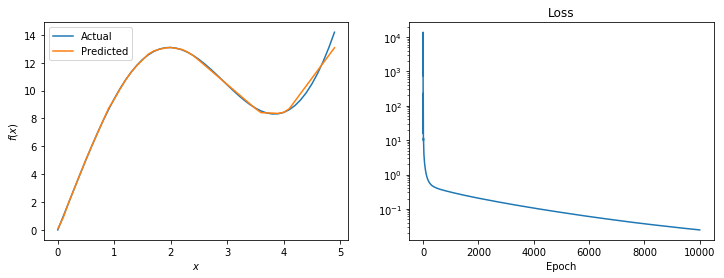

In [58]:
plot_results(x, y, Z, losses)

<p>
  If you did everything correctly, the result should look similar to this image:
</p>
<center>
   <img src="./p8/plot.png" width="800px" />
</center>

## Custom step-size decrease schedule 

In [59]:
# training data
x = np.arange(0, 5, 0.1)
y = (x ** 2 + 10*np.sin(x))
x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T

# transition function
f, delta_f = get_transition_func("ReLU")

# initialize weights, historical gradients, losses
weights = initweights([2,200,1])
losses = np.zeros(M)

hist_grad = np.copy(weights)
for j in range(len(weights)):
    hist_grad[j] = hist_grad[j] * 0

alpha = 0.02
M = 10000
beta = 0.8
eps = 1e-6

losses = np.zeros(M)
t0 = time.time()
for i in range(M):
    f, delta_f = get_transition_func("ReLU")
    A, Z = forward_pass(weights, x2d, f)
    losses[i] = compute_loss(Z,y)
    gradients = backprop(weights,A,Z,y,delta_f)
    for j in range(len(weights)):
        if i != 0:
            hist_grad[j] = beta * hist_grad[j] + (1 - beta) * gradients[j] ** 2
        else:
            hist_grad[j] = gradients[j] ** 2
        adj_grad = gradients[j] / (eps + np.sqrt(hist_grad[j]))
        weights[j] -= alpha * adj_grad
t1 = time.time()
print('Elapsed time: %.2fs (probably faster than Julia)' % (t1-t0))

Elapsed time: 4.26s (probably faster than Julia)


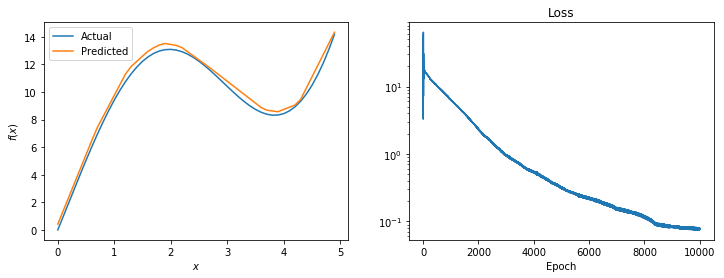

In [60]:
plot_results(x, y, Z, losses)

## Adagrad

In [61]:
# training data
x = np.arange(0, 5, 0.1)
y = (x ** 2 + 10*np.sin(x))
x2d = np.concatenate([x, np.ones(x.shape)]).reshape(2, -1).T

# transition function
f, delta_f = get_transition_func("ReLU")

# initialize weights, historical gradients, losses
weights = initweights([2,200,1])
losses = np.zeros(M)

hist_grad = np.copy(weights)
for j in range(len(weights)):
    hist_grad[j] = hist_grad[j] * 0

alpha = 0.02
M = 10000
beta = 0.8
eps = 1e-6

losses = np.zeros(M)
t0 = time.time()
for i in range(M):
    f, delta_f = get_transition_func("ReLU")
    A, Z = forward_pass(weights, x2d, f)
    losses[i] = compute_loss(Z,y)
    gradients = backprop(weights,A,Z,y,delta_f)
    for j in range(len(weights)):
        hist_grad[j] += gradients[j] ** 2
        adj_grad = gradients[j] / (eps + np.sqrt(hist_grad[j]))
        weights[j] -= alpha * adj_grad
t1 = time.time()
print('Elapsed time: %.2fs (probably faster than Julia)' % (t1-t0))

Elapsed time: 3.96s (probably faster than Julia)


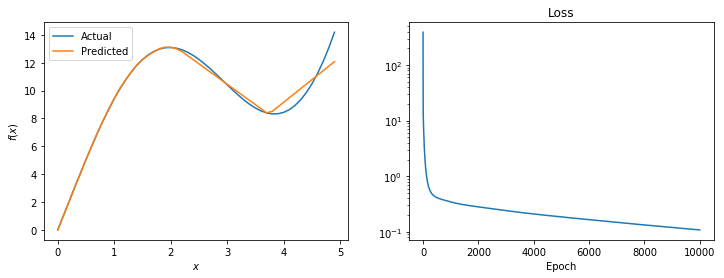

In [62]:
plot_results(x, y, Z, losses)